In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import timedelta
import matplotlib.pylab as plt
import glob
import time
from netCDF4 import Dataset

In [2]:
# Import the function from the modified script
from coare36vn_zrf_et_netCDF import coare36vn_zrf_et

In [3]:
# Define the path and file name
path = '/work/mh0731/m300868/10_COARE/'
file = 'ngc4008_to_COARE_input_trop_Pacific_2020_JAN.nc' #'ngc4008_to_COARE_input_trp_Pcf_2020.nc' #'ngc4008_to_COARE_input_global_ocean_2020.nc'

# Open the dataset
ds = xr.open_dataset(os.path.join(path, file))
ds;

In [4]:
# Create a temporary directory if it doesn't exist
temp_dir = '/work/mh0731/m300868/10_COARE/temp'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Define the output file header and variable names
var_names = ['usr', 'tau', 'hsb', 'hlb', 'hbb', 'hsbb', 'hlwebb', 'tsr', 'qsr', 
             'zo', 'zot', 'zoq', 'Cd', 'Ch', 'Ce', 'L', 'zeta', 'dT_skinx', 
             'dq_skinx', 'dz_skin', 'Urf', 'Trf', 'Qrf', 'RHrf', 'UrfN', 
             'TrfN', 'QrfN', 'lw_net', 'sw_net', 'Le', 'rhoa', 'UN', 'U10', 
             'U10N', 'Cdn_10', 'Chn_10', 'Cen_10', 'hrain', 'Qs', 'Evap', 
             'T10', 'T10N', 'Q10', 'Q10N', 'RH10', 'P10', 'rhoa10', 'gust', 
             'wc_frac', 'Edis']

# Function to save data to a NetCDF file
def save_batch(data_list, batch_index, cell_indices):
    fname = os.path.join(temp_dir, f'temp_batch_{batch_index}.nc')
    with Dataset(fname, 'w', format='NETCDF4') as ncfile:  # 'w' mode ensures overwriting
        nvars = len(var_names)
        nobs = data_list[0].shape[0]
        ncfile.createDimension('nvars', nvars)
        ncfile.createDimension('time', nobs)
        ncfile.createDimension('cell', len(data_list))
        
        cell_var = ncfile.createVariable('cell', 'i4', ('cell',))
        cell_var[:] = cell_indices
        
        for i, var_name in enumerate(var_names):
            var = ncfile.createVariable(var_name, 'f8', ('cell', 'time'))
            var_values = np.array([data[:, i] for data in data_list])
            var[:, :] = var_values
            var.units = 'unknown'  # You can add appropriate units here if known


In [5]:
# Assuming coare36vn_zrf_et function and ds dataset are defined elsewhere
cell_indices = ds.cell.values
total_cells = len(cell_indices)
start_time = time.time()

batch_size = 1000
data_list = []
batch_indices = []

# Iterate through cells using actual cell indices
for i, cell_index in enumerate(cell_indices):
    dataset = ds.sel(cell=cell_index)
    
    # Extract variables
    u = dataset['u'].values
    t = dataset['t'].values
    rh = dataset['rh'].values
    P = dataset['P'].values
    ts = dataset['ts'].values
    sw_dn = dataset['sw_dn'].values
    lw_dn = dataset['lw_dn'].values
    lat = dataset['lat'].values
    lon = dataset['lon'].values
    zi = dataset['zi'].values
    rain = dataset['rain'].values
    zu = dataset['zu'].values
    zt = dataset['zt'].values
    zq = dataset['zq'].values
    Ss = dataset['Ss'].values
    jd = dataset['jd'].values
    
    # Call the function with the extracted data
    A = coare36vn_zrf_et(u, zu, t, zt, rh, zq, P, ts, sw_dn, lw_dn, lat, lon, jd, zi, rain, Ss)
    
    # Accumulate data in lists
    data_list.append(A)
    batch_indices.append(cell_index)
    
    # Save the batch if the batch size is reached
    if (i + 1) % batch_size == 0 or (i + 1) == total_cells:
        save_batch(data_list, (i // batch_size), batch_indices)
        data_list = []
        batch_indices = []
        
        # Print progress and estimate remaining time
        elapsed_time = time.time() - start_time
        completed = i + 1
        remaining_time = (elapsed_time / completed) * (total_cells - completed)
        remaining_time_str = str(timedelta(seconds=int(remaining_time)))
        print(f'Batch {(i // batch_size) + 1} completed. Cells processed: {completed}/{total_cells}. Estimated time remaining: {remaining_time_str}.')

/home/m/m300868/00_PhD/03_TOGA_COARE/COARE-algorithm/Python/COARE3.6/coare36vn_zrf_et_netCDF.py:751: RuntimeWarning: invalid value encountered in power
  psi = - (((1 + 0.6667 * zeta) ** (1.5)) + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
/home/m/m300868/00_PhD/03_TOGA_COARE/COARE-algorithm/Python/COARE3.6/coare36vn_zrf_et_netCDF.py:716: RuntimeWarning: invalid value encountered in power
  wc_frac = 0.00073 * ((U10N - 2) ** (1.43))


Batch 1 completed. Cells processed: 1000/74824. Estimated time remaining: 0:15:57.
Batch 2 completed. Cells processed: 2000/74824. Estimated time remaining: 0:15:58.
Batch 3 completed. Cells processed: 3000/74824. Estimated time remaining: 0:15:49.
Batch 4 completed. Cells processed: 4000/74824. Estimated time remaining: 0:15:37.
Batch 5 completed. Cells processed: 5000/74824. Estimated time remaining: 0:15:26.
Batch 6 completed. Cells processed: 6000/74824. Estimated time remaining: 0:15:14.
Batch 7 completed. Cells processed: 7000/74824. Estimated time remaining: 0:15:01.
Batch 8 completed. Cells processed: 8000/74824. Estimated time remaining: 0:14:48.
Batch 9 completed. Cells processed: 9000/74824. Estimated time remaining: 0:14:35.
Batch 10 completed. Cells processed: 10000/74824. Estimated time remaining: 0:14:23.
Batch 11 completed. Cells processed: 11000/74824. Estimated time remaining: 0:14:10.
Batch 12 completed. Cells processed: 12000/74824. Estimated time remaining: 0:13:57

/home/m/m300868/00_PhD/03_TOGA_COARE/COARE-algorithm/Python/COARE3.6/coare36vn_zrf_et_netCDF.py:701: RuntimeWarning: invalid value encountered in sqrt
  QN = Q + np.multiply(np.multiply(psiT,1000.0),qsr) / von / np.sqrt(gf)


Batch 39 completed. Cells processed: 39000/74824. Estimated time remaining: 0:08:00.
Batch 40 completed. Cells processed: 40000/74824. Estimated time remaining: 0:07:46.
Batch 41 completed. Cells processed: 41000/74824. Estimated time remaining: 0:07:33.
Batch 42 completed. Cells processed: 42000/74824. Estimated time remaining: 0:07:20.
Batch 43 completed. Cells processed: 43000/74824. Estimated time remaining: 0:07:06.
Batch 44 completed. Cells processed: 44000/74824. Estimated time remaining: 0:06:53.
Batch 45 completed. Cells processed: 45000/74824. Estimated time remaining: 0:06:39.
Batch 46 completed. Cells processed: 46000/74824. Estimated time remaining: 0:06:26.
Batch 47 completed. Cells processed: 47000/74824. Estimated time remaining: 0:06:13.
Batch 48 completed. Cells processed: 48000/74824. Estimated time remaining: 0:05:59.
Batch 49 completed. Cells processed: 49000/74824. Estimated time remaining: 0:05:46.
Batch 50 completed. Cells processed: 50000/74824. Estimated time 

# Merging Files

In [6]:
# Define the directory where the NetCDF files are stored
temp_dir = '/work/mh0731/m300868/10_COARE/temp'

# Create a pattern to match all NetCDF files
file_pattern = os.path.join(temp_dir, 'temp_*.nc')

# Open all NetCDF files as a single xarray dataset
ds = xr.open_mfdataset(file_pattern, combine='by_coords')
ds

<xarray.Dataset> Size: 898MB
Dimensions:   (cell: 74824, time: 30)
Coordinates:
  * cell      (cell) int32 299kB 0 1 2 3 4 5 ... 74819 74820 74821 74822 74823
Dimensions without coordinates: time
Data variables: (12/50)
    usr       (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    tau       (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    hsb       (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    hlb       (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    hbb       (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    hsbb      (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    ...        ...
    RH10      (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    P10       (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    rhoa10    (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    gust      (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    wc_frac   (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>
    Edis      (cell, time) float64 18MB dask.array<chunksize=(1000, 30), meta=np.ndarray>

# Saving Files

In [12]:
ds.to_netcdf("/work/mh0731/m300868/10_COARE/ngc4008_to_COARE_trop_Pacific_2020_JAN_output.nc")

# Test Plot

In [7]:
coare_Cd = ds.Cd

In [8]:
coare_U10 = ds.U10

Text(0.5, 0, 'Wind Velocity / m$s^{-1}$')

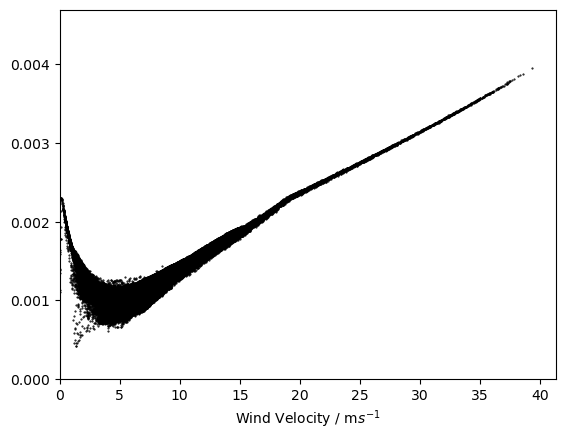

In [9]:
plt.scatter(coare_U10, coare_Cd, marker='.', s=1, color='black', alpha=1)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel(r'Wind Velocity / m$s^{-1}$')